In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

os.environ['KAGGLE_USERNAME'] = 'skirmantevaisnoraite'

# username from the json file

os.environ['KAGGLE_KEY'] = "0b6de90c38bbcf5902061c51887a53b4"

# key from the json file

In [5]:
!kaggle datasets download -d agrigorev/clothing-dataset-full

100% 6.50G/6.50G [00:36<00:00, 229MB/s]
100% 6.50G/6.50G [00:36<00:00, 190MB/s]


In [ ]:
!cp clothing-dataset-full.zip drive/MyDrive/projectData.zip

In [6]:
!unzip clothing-dataset-full.zip > /dev/null

In [ ]:
!pip install snoop
!pip install polars
from fastai.vision.all import *
import polars as pl
from snoop import pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# cfg = pl.Config.restore_defaults()  
pl.Config.set_tbl_rows(50)  
pl.Config.set_fmt_str_lengths(1000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


polars.config.Config

polars.config.Config

In [7]:
import pandas as pd
img_csv = pd.read_csv('images.csv', sep=",")
img_csv

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [8]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [10]:
columns_to_exclude = ['Not sure', 'Skip', 'Blouse', 'Top', 'Undershirt', 
                      'Blazer', 'Hoodie', 'Body', 'Other', 'Polo', 'Hat']

for i in columns_to_exclude:
  img_csv = img_csv[img_csv['label'] != i]

len(img_csv)

4343

In [ ]:
img_csv['label'].nunique()

8

In [11]:
img_csv['label'].unique()

array(['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Outwear',
       'Dress', 'Longsleeve'], dtype=object)

In [12]:
img_csv['label'].value_counts()

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Skirt          155
Name: label, dtype: int64

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=img_csv,
    x='label',
    palette='Set1')
# chart = sns.histplot(data=img_csv, x="label")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
img_csv

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt
%matplotlib inline
def return_image_embedding(model,img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
img_path = 'food101/images/image_french_fries_692.jpeg'
return_image_embedding(model,img_path)

94765736/94765736 [==============================] - 0s 0us/step


FileNotFoundError: ignored

In [14]:
img_csv['image'] = img_csv['image']+'.jpg'
img_csv = img_csv[['image', 'label']]

In [15]:
img_csv['image']

1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
5       5d3a1404-697f-479f-9090-c1ecd0413d27.jpg
6       b0c03127-9dfb-4573-8934-1958396937bf.jpg
                          ...                   
5397    3855ea22-5e7f-411f-b1fa-6db27a676c06.jpg
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 4343, dtype: object

In [ ]:
# TRAINING_DIR = 'images_compressed/'
# IMAGE_SIZE = (224,224)
# BATCH_SIZE = 64

# train_datagen = ImageDataGenerator(
# rescale=1./255, rotation_range=40, width_shift_range=0.3,
# height_shift_range=0.3, zoom_range=0.3, horizontal_flip=True, validation_split=0.1)

# train_generator = train_datagen.flow_from_dataframe(
# dataframe=img_csv, directory=TRAINING_DIR, x_col='image', y_col='image', 
# target_size=IMAGE_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=False, subset='training' )

Found 4863 validated image filenames.


In [ ]:
!pwd

/content


In [16]:
import os

failed = [
    'images_compressed/c79626da-ec15-4905-9980-9cba60b36c4f.jpg',
    'images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg',
    'images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg',
    'images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg',
    'images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
    'images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg',
    'images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg',
    'images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']


for i in failed:
   os.remove(i)

FileNotFoundError: ignored

In [ ]:
img_csv = img_csv[img_csv['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg' ]
img_csv = img_csv[img_csv['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg' ]
img_csv = img_csv[img_csv['image'] != 'b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg' ]
img_csv = img_csv[img_csv['image'] != '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg' ]
img_csv = img_csv[img_csv['image'] != 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg' ]
img_csv = img_csv[img_csv['image'] != 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg' ]
img_csv = img_csv[img_csv['image'] != '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg' ]
img_csv = img_csv[img_csv['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg' ]


len(img_csv)

4322

In [ ]:
# model = Img2Vec()
model = ResNet50(weights='imagenet', include_top=False,pooling='avg')

def return_image_embedding(model,img_path):
    img_path = f'images_compressed/{img_path}'
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
images_path = os.listdir('images_compressed/')
train_embeddings = pd.DataFrame()
for curr_img in tqdm(images_path):
    curr_df = return_image_embedding(model,curr_img)
    curr_df['image'] = curr_img
    train_embeddings = pd.concat([train_embeddings,curr_df],ignore_index=True)

In [18]:
from pathlib import Path  
filepath = Path('/content/train.csv')
train_embeddings.to_csv(filepath)

In [83]:
# train_embeddings = pd.read_csv('drive/MyDrive/baigiamasis_darbas/train.csv')

train_embeddings = train_embeddings[train_embeddings['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'c79626da-ec15-4905-9980-9cba60b36c4f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'be5abec7-c658-4249-a15c-629557cc7441.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'ed484135-7bf9-4734-8323-d2f3b3d640fa.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '72239b49-3abe-42aa-b4fb-b39436becefb.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '8d9bc810-e146-4160-aeeb-47a5e131c56e.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'fe94de4f-958b-4a4f-a8d9-37748a70717d.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '8634bf59-371c-41d6-a7b2-b7592b2b2482.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '0197156f-b604-49bc-93ae-43ba0b8e2cd8.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'eaae2224-e417-465c-bd7a-60feeb33a864.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '9ef2b0b2-bf6f-4544-83eb-b69f785561c6.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '6a06dfe2-5e0f-4e2f-875d-56f159de38ab.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '6388d73a-66b0-4c68-9a3b-2a1a71d1df6c.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != 'b2ee19d6-93f1-4688-9545-d265887f226f.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '97d79060-78c0-4111-af1b-57d1475aa0f2.jpg']
train_embeddings = train_embeddings[train_embeddings['image'] != '4bb006b8-1b11-443d-abb6-62b38a6228fc.jpg']
for i in not_found_neighbours:
  train_embeddings = train_embeddings[train_embeddings['image'] != i]

In [ ]:
train_embeddings

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
image_to_delete = []
train_embeddings['True_label'] = None

for i in train_embeddings.index:
  image = train_embeddings['image'][i]
  find_in_csv = img_csv[img_csv['image'] == image].index
  try:
    if find_in_csv[0] != 0:
      index_N = img_csv[img_csv['image']==image].index
      train_embeddings['True_label'][i] = img_csv['label'][index_N[0]]
  except Exception as e:
    image_to_delete.append(image)
    train_embeddings['True_label'][i] = None
    print(e)

In [27]:
train_embeddings = filter_rows_by_values(train_embeddings, 'image', image_to_delete)

In [67]:
len(image_to_delete)
# len(train_embeddings)

1412

In [ ]:
train_embeddings

In [ ]:
print(model.summary())

In [ ]:
test_list = os.listdir('/content/Skirmante_darbas/Test_df.xlsx')
test_list

In [29]:
test_df = pd.read_excel('/content/Skirmante_darbas/Test_df.xltx')

embedding

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt
%matplotlib inline


def return_image_embedding(model,img_path):
    img = image.load_img(f'drive/MyDrive/baigiamasis_darbas/test/{img_path}', target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    curr_df = pd.DataFrame(preds[0]).T
    return curr_df
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
images_path = os.listdir('drive/MyDrive/baigiamasis_darbas/test/')
test_embeddings = pd.DataFrame()
for curr_img in tqdm(images_path):
    curr_df = return_image_embedding(model,curr_img)
    curr_df['image'] = curr_img
    test_embeddings = pd.concat([test_embeddings,curr_df],ignore_index=True)


In [ ]:
test_embeddings

In [ ]:
test_embeddings.to_csv('drive/MyDrive/baigiamasis_darbas/test.csv')

In [31]:
test_embeddings = pd.read_csv('/content/test.csv')

In [ ]:
test_embeddings

In [ ]:
train_embeddings

In [34]:
train_embeddings.drop(['Unnamed: 0'], axis=1)
len(train_embeddings)

KeyError: ignored

cosine similarity

In [68]:
from joblib import Memory
def get_similar_items_sklearn(embedding_test: np.array, embedding_train: np.array, n_neighbours=20, save=False, weights='distance'): 
  nbrs = NearestNeighbors( n_neighbors=n_neighbours, algorithm="brute", metric="cosine", n_jobs=-1 ).fit(embedding_train) 
  if save: 
    joblib.dump(nbrs, "nearestNeighbors_model.pkl") 
  return nbrs.kneighbors(embedding_test, 2, return_distance=True),nbrs

In [38]:
embedding_test = test_embeddings.drop(['image', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [ ]:
embedding_test

In [85]:
embedding_train = train_embeddings.drop(['image', 'Unnamed: 0','True_label'], axis=1)

In [ ]:
embedding_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.013084,0.872130,0.000000,0.000000,0.314292,0.242631,0.000000,0.029941,0.000000,0.093152,...,0.257382,0.015977,0.002337,0.040406,0.000000,0.060897,0.005766,0.403669,0.000000,0.182571
2,0.557463,0.150888,0.383728,0.222010,0.588284,0.000000,0.421334,0.763659,0.257089,0.835427,...,0.000000,0.149221,1.183229,0.595600,0.637388,0.136608,0.397057,0.000000,0.237488,0.102041
3,0.175626,4.137378,0.849400,0.000000,0.122685,0.008217,0.259555,0.021968,0.000000,0.000000,...,1.009706,0.004911,0.000000,0.000000,0.021271,0.281904,0.079760,0.113474,0.254968,3.239079
4,0.164533,4.622841,0.067492,0.570673,0.306231,0.000000,0.114263,0.009764,0.000000,0.024356,...,0.053309,0.005556,0.004783,0.000000,0.000000,0.000000,0.204968,0.439291,0.111616,0.424170
8,0.046711,2.745470,0.022015,0.082795,0.456066,0.608057,0.163130,0.732880,0.000000,0.000000,...,0.430460,0.207708,0.020538,0.000000,0.122049,0.098182,0.065045,0.000000,0.067809,0.053561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,0.411276,2.266398,0.501076,0.690352,0.743088,0.310442,0.338474,0.170552,0.007399,0.013685,...,0.637864,0.234518,0.000000,0.103116,0.099809,0.005662,0.024468,0.683116,0.002807,1.750065
5751,0.136872,2.230986,0.007429,0.156681,0.396972,0.085962,1.731753,0.702506,0.032111,0.008711,...,0.189393,0.006766,0.000000,0.000000,0.000000,0.025010,0.127018,0.262115,0.687713,1.493636
5752,0.097682,6.251052,0.249771,0.353585,0.309125,0.080612,0.101036,0.629772,0.079023,0.035590,...,2.194046,0.402112,0.014157,0.000000,0.049976,0.000000,0.880223,1.143147,0.209456,1.495267
5753,0.151247,2.028732,0.282341,0.397360,0.012897,0.000802,1.231175,0.159924,0.288879,1.051897,...,0.019750,0.054975,0.000000,0.010751,0.058326,0.085673,0.101388,0.000000,0.035367,3.479569


In [86]:
distances_between_photos, nbrs = get_similar_items_sklearn(embedding_test, embedding_train)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


In [ ]:
distances_between_photos

In [ ]:
distances, neighbours = zip(distances_between_photos)

import numpy as np 

distances_list =[]
for i in distances:
  for n in i:
    distances_list.append(n)

neighbours_list=[]
for i in neighbours:
  for n in i:
    neighbours_list.append(n)  

df_neigbours_distances = pd.DataFrame({'distances':np.array(distances_list).reshape([len(embedding_test), -1]).tolist(), 'neighbours':np.array(neighbours_list).reshape([len(embedding_test), -1]).tolist()}) 
df_neigbours_distances

In [88]:
last_df = pd.concat([df_neigbours_distances, test_embeddings['image']], ignore_index=True, axis=1)

In [ ]:
last_df

# New section

# New section

In [89]:
similars = []

for i in last_df[1].values:
  neighbour_1 = train_embeddings.iloc[i[0]]['image']
  neighbour_2 = train_embeddings.iloc[i[1]]['image']
  similars.append([neighbour_1, neighbour_2])

similars = pd.DataFrame(similars)

In [90]:
similar_photos = pd.concat([last_df, similars],ignore_index=True, axis=1)

In [91]:
similar_photos = similar_photos.rename(columns={0:'distances', 1:'neighbours', 2:'test_list', 3:'neighbour_1', 4:'neighbour_2'})

In [ ]:
similar_photos

In [79]:
import cv2
import matplotlib.pyplot as plt 

def show_img(img_path):
    print(img_path)
    im = cv2.imread(img_path)
    im = cv2.resize(im, (244, 244))
    plt.axis('off')
    plt.imshow(im[:,:,::-1])
    plt.title(img_path)
    plt.show()

In [ ]:
counter = 0
for test, n_1, n_2 in zip(similar_photos['test_list'],similar_photos['neighbour_1'], similar_photos['neighbour_2']):
  test_img_path = 'drive/MyDrive/baigiamasis_darbas/test/'+str(test)
  show_img(test_img_path)
  train_img_path = '/content/images_original/'+str(n_1)
  show_img(train_img_path)
  train_img_path = '/content/images_original/'+str(n_2)
  show_img(train_img_path)
  counter = counter + 1
  if counter == 3:
    break

In [92]:
from sklearn.metrics import confusion_matrix

with_labels = pd.merge(
    test_df,
    similar_photos,
    how="inner",left_on='test_list',
    right_on='test_list')
with_labels['true_label'] = with_labels['label']
with_labels.drop(columns='label')

with_labels['nearest_neighbour'] = None
for i in similar_photos.index:
  if i >= len(similar_photos) -1:
    break
  distances = similar_photos['distances'][i]
  if distances[0]> distances[1]:
    with_labels['nearest_neighbour'][i] = with_labels['neighbour_2'][i]
  else:
    with_labels['nearest_neighbour'][i] = with_labels['neighbour_1'][i]

not_found_neighbours = []
with_labels['Predicted_label'] = None
for i in similar_photos.index:
  if i >= len(similar_photos) -1:
    break
  nearest_neighbour = with_labels['nearest_neighbour'][i]
  index_N = img_csv[img_csv['image']==nearest_neighbour].index
  try:
    with_labels['Predicted_label'][i] = img_csv['label'][index_N[0]]
  except Exception as e:
    not_found_neighbours.append(nearest_neighbour)
    print(nearest_neighbour)


In [ ]:
img_csv

In [ ]:
with_labels

In [93]:
cmx = confusion_matrix(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist(), labels=with_labels['true_label'].unique())
df = pd.DataFrame(cmx, columns=with_labels['true_label'].unique(), index=with_labels['true_label'].unique())
df.columns.name = 'prediction'
df

prediction,Dress,Shoes,Pants,Longsleeve,Shorts,T-Shirt,Skirt,Other,Outwear
Dress,3,0,0,1,0,1,0,0,0
Shoes,0,6,0,0,0,0,0,0,0
Pants,1,0,10,0,0,0,0,0,0
Longsleeve,1,0,0,0,0,1,0,0,0
Shorts,0,0,2,0,3,1,0,0,0
T-Shirt,6,0,4,1,0,9,0,0,0
Skirt,0,0,1,0,0,0,1,0,0
Other,0,0,0,0,0,1,0,0,0
Outwear,0,0,0,0,0,0,0,0,1


In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score

classif = classification_report(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist())

print(classif)

accuracy_score(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist())

precision_score(with_labels['true_label'].tolist(), with_labels['Predicted_label'].tolist(), average='macro')

              precision    recall  f1-score   support

       Dress       0.27      0.60      0.37         5
  Longsleeve       0.00      0.00      0.00         2
       Other       0.00      0.00      0.00         1
     Outwear       1.00      1.00      1.00         1
       Pants       0.59      0.91      0.71        11
       Shoes       1.00      1.00      1.00         6
      Shorts       1.00      0.50      0.67         6
       Skirt       1.00      0.50      0.67         2
     T-Shirt       0.69      0.45      0.55        20

    accuracy                           0.61        54
   macro avg       0.62      0.55      0.55        54
weighted avg       0.68      0.61      0.61        54



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

0.6170300287947348

In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV

n_neighbors = [100, 3, 25, 1]
for n in n_neighbors:
  nbrs1 = NearestNeighbors(n_neighbors=n, algorithm="ball_tree", metric="minkowski", n_jobs=-1).fit(embedding_train) 
  predictions = nbrs1.kneighbors(embedding_test, 1, return_distance=True)
  print(predictions)
  df_predictions = pd.DataFrame({'distances':np.array(predictions[0]).reshape([len(embedding_test),-1]).tolist(), 
                                 'neighbours':np.array(predictions[1]).reshape([len(embedding_test),-1]).tolist()}) 
  predicrions_df = pd.concat([df_predictions, test_embeddings['image']],ignore_index=True, axis=1)
  predicrions_df = predicrions_df.rename(columns={2: 'test_list'})
  closest = []
  for i in last_df[1].values:
    neighbour_1 = train_embeddings.iloc[i[0]]['image']
    closest.append(neighbour_1)
  predicrions_df['neighbor'] = closest
  after_grid = pd.merge(
    test_df,
    predicrions_df,
    how="inner",left_on='test_list',
    right_on='test_list')
  after_grid['true_label'] = after_grid['label']
  after_grid.drop(columns='label')
  after_grid['Predicted_label'] = None

  for i in predicrions_df.index:
    if i >= len(test_embeddings)-1:
      break
    neighbor = after_grid['neighbor'][i]
    index_N = img_csv[img_csv['image']==neighbor].index
    try:
      after_grid['Predicted_label'][i] = img_csv['label'][index_N[0]]
    except Exception as e:
      print(e)
  accuraccy = accuracy_score(after_grid['true_label'].tolist(), after_grid['Predicted_label'].tolist())
  print(accuraccy, n)

In [ ]:
predicrions_df

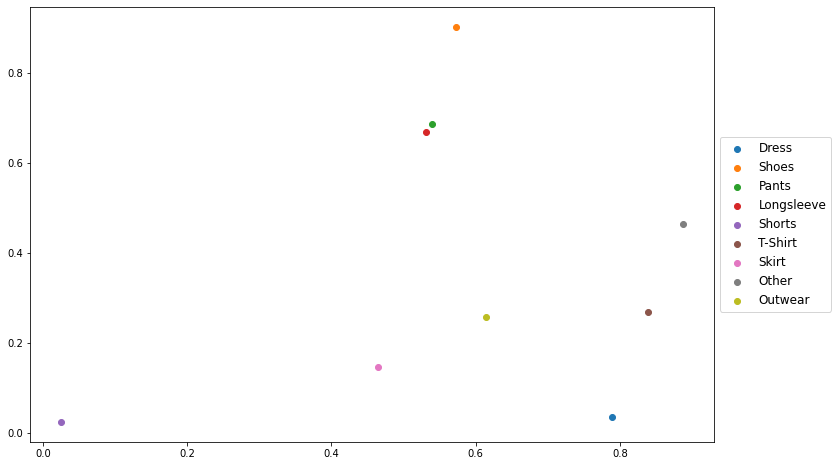

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# Random 2D points to make scatter plot
x = [np.random.random() for i in range(len(with_labels['true_label'].unique()))]
y = [np.random.random() for i in range(len(with_labels['true_label'].unique()))]

fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(111)



colors = plt.cm.rainbow(np.linspace(0, 1, len(with_labels['true_label'].unique())))

for i, j, name in zip(x, y, with_labels['true_label'].unique()):
    ax.scatter(i, j, label=name)

fig.subplots_adjust(right=0.6)  # This is needed so that the legend is not cut out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.show()


4 4


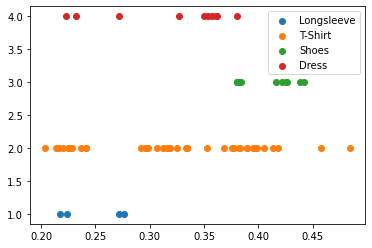

In [123]:
import matplotlib.pyplot as plt

y3 =  2*len(with_labels[with_labels['label']=='Dress']['distances'].tolist())*[4]
x3 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Dress']['distances'].tolist()))
y2 =  2*len(with_labels[with_labels['label']=='Shoes']['distances'].tolist())*[3]
x2 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Shoes']['distances'].tolist()))
y1 =  2*len(with_labels[with_labels['label']=='T-Shirt']['distances'].tolist())*[2]
x1 = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='T-Shirt']['distances'].tolist()))
y =  2*len(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist())*[1]
x = [0]+np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist()))

plt.scatter(x, y, label='Longsleeve')
plt.scatter(x1, y1, label='T-Shirt')
plt.scatter(x2, y2, label='Shoes')
plt.scatter(x3, y3, label='Dress')
plt.legend()
plt.show()

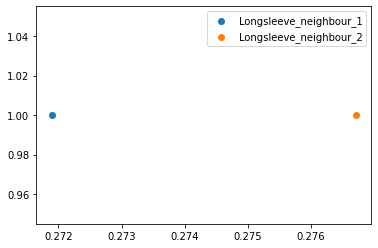

In [133]:
import matplotlib.pyplot as plt
y =  2*len(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist())*[1]
x = np.ndarray.flatten(np.array(with_labels[with_labels['label']=='Longsleeve']['distances'].tolist()))
plt.scatter(x[0], y[0], label='Longsleeve_neighbour_1')
plt.scatter(x[1], y[1], label='Longsleeve_neighbour_2')
plt.legend()
plt.show()

In [ ]:
with_labels['distances'][0]

[0.2718258151035554, 0.300930651569116]

In [ ]:
with_labels[with_labels['label']=='Dress']['distances'].tolist()

[[0.2718258151035554, 0.300930651569116],
 [0.34962596328288753, 0.35338324964372914],
 [0.3623040596770055, 0.3800429911198454],
 [0.34412798612250184, 0.35725334796443353],
 [0.22250638606788975, 0.23167617350699388]]

In [ ]:
len(with_labels[with_labels['label']=='Dress']['distances'].tolist())

5

In [ ]:
konfussion matrica( oroginal, labels, train img ir jo labels -- lentele su stupeliais)

In [ ]:
subalansuot dataseta

In [ ]:
imesti kaciuka ar suniuka

In [ ]:
githuba ideti

In [ ]:
gridsearcha

In [ ]:
skaidres pradeti daryti(biski apie resnet, apie kneighboars)

In [ ]:
daugiau paveiksluku i dataset i klase other spriskityi
